**Exercise 2 - Web crawling using BeautifulSoup and text processing**


Name:Albin Lamichhane

Tampere University




In [ ]:
import requests
from bs4 import BeautifulSoup
import re
import nltk
import numpy as np
nltk.download('punkt')





[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

**Exercise 2.1**
The web crawler code shown on Lecture 2 is poor in at least two respects:
1. It can crawl the same page multiple times, if a link on a later crawled page points to the
already-crawled page.
2. It inserts all links from each page in order as pages to be crawled. If some page contains
thousands of links, the crawling will crawl those first and may never get to the links from
the next page, especially if the total number of pages are limited.
Suggest how to create an improved web crawler that does not have these problems. Provide in your
answer the improved code, either as pseudocode or as real code in Python or in another
programming language. The code must be detailed enough to show how the problem is solved using
the data types and structures of the language you have chosen.


In [ ]:
#%% Find linked pages in Finnish sites, but not PDF or PS files
def getpageurls(webpage_parsed):
 # Find elements that are hyperlinks
    pagelinkelements=webpage_parsed.find_all('a')
    pageurls=[];
    for pagelink in pagelinkelements:
        pageurl_isok=1
        try:
            pageurl=pagelink['href']
        except:
            pageurl_isok=0
        if pageurl_isok==1:
            # Check that the url does NOT contain these strings
            if (pageurl.find('.pdf')!=-1)|(pageurl.find('.ps')!=-1):
                pageurl_isok=0
            # Check that the url DOES contain these strings
            if (pageurl.find('http')==-1)|(pageurl.find('.fi')==-1):
                pageurl_isok=0
        if pageurl_isok==1:
            pageurls.append(pageurl)
   
    return(pageurls)

In [ ]:
#%% Get the text content of the page
def getpagetext(parsedpage):
    # Remove HTML elements that are scripts
    scriptelements=parsedpage.find_all('script')
    # Concatenate the text content from all table cells
    for scriptelement in scriptelements:
        # Extract this script element from the page.
        # This changes the page given to this function!
        scriptelement.extract()
    pagetext=parsedpage.get_text()
    return(pagetext)


In [ ]:
crawled_urls = set() # stores the crawled urls
def basicwebcrawler(seedpage_url,maxpages):
    # Store URLs crawled and their text content
    num_pages_crawled=0
    #crawled_urls=[]
    global crawled_urls
    crawled_texts=[]
    # Remaining pages to crawl: start from a seed page URL
    pagestocrawl=[seedpage_url]
    # Process remaining pages until a desired number
    # of pages have been found
    while (num_pages_crawled<maxpages)&(len(pagestocrawl)>0):
        # Retrieve the topmost remaining page and parse it
        pagetocrawl_url=pagestocrawl[0]
        print('Getting page:')
        print(pagetocrawl_url)
        pagetocrawl_html=requests.get(pagetocrawl_url)
        pagetocrawl_parsed=BeautifulSoup(pagetocrawl_html.content,'html.parser')
        # Get the text and URLs of the page
        # we check if pagetocrawl_url is already crawled
        if pagetocrawl_url not in crawled_urls:
            pagetocrawl_text=getpagetext(pagetocrawl_parsed)
            pagetocrawl_urls=getpageurls(pagetocrawl_parsed)
            num_pages_crawled=num_pages_crawled+1
            crawled_urls.add(pagetocrawl_url)
            crawled_texts.append(pagetocrawl_text)
            pagestocrawl=pagestocrawl[1:len(pagestocrawl)]
            pagestocrawl.extend(pagetocrawl_urls)
            
    return(crawled_urls,crawled_texts, num_pages_crawled)


In [ ]:
crawled_urls, crawled_texts, num_pages_crawled = basicwebcrawler('https://homepages.tuni.fi/jaakko.peltonen/', 10)

Getting page:
https://homepages.tuni.fi/jaakko.peltonen/
Getting page:
https://www.tuni.fi/en
Getting page:
https://www.tuni.fi/en/about-us/faculty-information-technology-and-communication-sciences
Getting page:
https://www.tuni.fi/en/about-us/computing-sciences
Getting page:
http://cs.aalto.fi/en/
Getting page:
http://www.cis.hut.fi/projects/mi
Getting page:
http://users.ics.aalto.fi/jtpelto/
Getting page:
http://research.ics.aalto.fi/coin/
Getting page:
https://www.tuni.fi/studentsguide/curriculum/degree-programmes/uta-tohjelma-1717?year=2019
Getting page:
https://www.tuni.fi/en/study-with-us/computing-sciences-data-science?navref=curated--list


**Exercises2.2**
Exercise 2.2: Data acquisition and processing from Project Gutenberg.
In this exercise we will process top-downloaded public domain ebooks from Project Gutenberg.
(a) Create a variant of the web crawler which is intended to download the top-k most
downloaded ebooks of the last 30 days from Project Gutenberg in .TXT format.
(b) Using the crawler, download the top-20 ebooks (k=20). Report the names and addresses of
the books.
(c) Use the processing pipeline described on the lecture to tokenize and lemmatize the
downloaded books.
(d) Create a unified vocabulary from the ebooks; report the top-100 words.

In [1]:
ebook_addresses = set() # stores unique ebook addresses
def top_k_downloaded_ebooks(seed_page_url, top_k):
    global ebook_addresses
    ebook_names = []
    num_downloaded_ebooks = 0
    downloaded_texts = []
    download_base_url = 'https://www.gutenberg.org/files/'
    seed_page_parsed = requests.get(seed_page_url)
    soup = BeautifulSoup(seed_page_parsed.content, 'html.parser')
    h2_tag = soup.find(id='books-last30')
    ol_tag = h2_tag.next_sibling.next_sibling
    for a_tag in ol_tag.find_all('a'):
        # find matching pattern for ebook name
        name_match = re.match(r'(.*)(\(\d+\))', a_tag.text)
        ebook_name = name_match.group(1).strip()
        # find matching pattern for ebook id
        id_match = re.match(r'/ebooks/(\d+)', a_tag.get('href'))
        ebook_id = id_match.group(1)
        # form download url of an ebook
        ebook_url = download_base_url + ebook_id + '/' + ebook_id + '-0.txt'
        # avoid downloading same text document multiple times
        if (ebook_url not in ebook_addresses) & (num_downloaded_ebooks < top_k):
            print('Downloading text file from:')
            print(ebook_url)
            ebook_page = requests.get(ebook_url)
            parsed_page = BeautifulSoup(ebook_page.content, 'html.parser')
            # get text from the ebook
            ebook_text = getpagetext(parsed_page)
            start_index = ebook_text.find('*** START OF THE PROJECT GUTENBERG EBOOK')
            end_index = ebook_text.find('*** END OF THE PROJECT GUTENBERG EBOOK')
            ebook_text = ebook_text[start_index:end_index]
            # remove leading and trailing whitespaces
            ebook_text = ebook_text.strip()
            ebook_text = ' '.join(ebook_text.split())
            # store book content
            downloaded_texts.append(ebook_text)
            ebook_addresses.add(ebook_url)
            ebook_names.append(ebook_name)
            num_downloaded_ebooks += 1
            
                
    return(downloaded_texts, ebook_names, ebook_addresses, num_downloaded_ebooks)

In [ ]:
downloaded_texts,ebook_names,ebook_addresses,num_downloaded_ebooks = top_k_downloaded_ebooks('https://www.gutenberg.org/browse/scores/top', 20)

https://www.gutenberg.org/files/2641/2641-0.txt
https://www.gutenberg.org/files/145/145-0.txt
https://www.gutenberg.org/files/37106/37106-0.txt
https://www.gutenberg.org/files/16389/16389-0.txt
https://www.gutenberg.org/files/67979/67979-0.txt
https://www.gutenberg.org/files/394/394-0.txt
https://www.gutenberg.org/files/1342/1342-0.txt
https://www.gutenberg.org/files/84/84-0.txt
https://www.gutenberg.org/files/2701/2701-0.txt
https://www.gutenberg.org/files/345/345-0.txt
https://www.gutenberg.org/files/1661/1661-0.txt
https://www.gutenberg.org/files/1952/1952-0.txt
https://www.gutenberg.org/files/11/11-0.txt
https://www.gutenberg.org/files/25344/25344-0.txt
https://www.gutenberg.org/files/174/174-0.txt
https://www.gutenberg.org/files/1080/1080-0.txt
https://www.gutenberg.org/files/98/98-0.txt
https://www.gutenberg.org/files/43/43-0.txt
https://www.gutenberg.org/files/100/100-0.txt
https://www.gutenberg.org/files/64317/64317-0.txt


In [ ]:
ebook_names

['A Room with a View by E. M.  Forster',
 'Middlemarch by George Eliot',
 'Little Women; Or, Meg, Jo, Beth, and Amy by Louisa May Alcott',
 'The Enchanted April by Elizabeth Von Arnim',
 'The Blue Castle: a novel by L. M.  Montgomery',
 'Cranford by Elizabeth Cleghorn Gaskell',
 'Pride and Prejudice by Jane Austen',
 'Frankenstein; Or, The Modern Prometheus by Mary Wollstonecraft Shelley',
 'Moby Dick; Or, The Whale by Herman Melville',
 'Dracula by Bram Stoker',
 'The Adventures of Sherlock Holmes by Arthur Conan Doyle',
 'The Yellow Wallpaper by Charlotte Perkins Gilman',
 "Alice's Adventures in Wonderland by Lewis Carroll",
 'The Scarlet Letter by Nathaniel Hawthorne',
 'The Picture of Dorian Gray by Oscar Wilde',
 'A Modest Proposal by Jonathan Swift',
 'A Tale of Two Cities by Charles Dickens',
 'The Strange Case of Dr. Jekyll and Mr. Hyde by Robert Louis Stevenson',
 'The Complete Works of William Shakespeare by William Shakespeare',
 'The Great Gatsby by F. Scott  Fitzgerald']

In [ ]:
ebook_addresses

{'https://www.gutenberg.org/files/100/100-0.txt',
 'https://www.gutenberg.org/files/1080/1080-0.txt',
 'https://www.gutenberg.org/files/11/11-0.txt',
 'https://www.gutenberg.org/files/1342/1342-0.txt',
 'https://www.gutenberg.org/files/145/145-0.txt',
 'https://www.gutenberg.org/files/16389/16389-0.txt',
 'https://www.gutenberg.org/files/1661/1661-0.txt',
 'https://www.gutenberg.org/files/174/174-0.txt',
 'https://www.gutenberg.org/files/1952/1952-0.txt',
 'https://www.gutenberg.org/files/25344/25344-0.txt',
 'https://www.gutenberg.org/files/2641/2641-0.txt',
 'https://www.gutenberg.org/files/2701/2701-0.txt',
 'https://www.gutenberg.org/files/345/345-0.txt',
 'https://www.gutenberg.org/files/37106/37106-0.txt',
 'https://www.gutenberg.org/files/394/394-0.txt',
 'https://www.gutenberg.org/files/43/43-0.txt',
 'https://www.gutenberg.org/files/64317/64317-0.txt',
 'https://www.gutenberg.org/files/67979/67979-0.txt',
 'https://www.gutenberg.org/files/84/84-0.txt',
 'https://www.gutenberg.

In [ ]:
# Tokenize downloaded texts and change them to NLTK format
mydownloaded_nltk_texts = []
for k in range(len(downloaded_texts)):
    temp_tokenizedtext = nltk.word_tokenize(downloaded_texts[k])
    temp_nltktext = nltk.Text(temp_tokenizedtext)
    mydownloaded_nltk_texts.append(temp_nltktext)

In [ ]:
mydownloaded_nltk_texts[:30]


[<Text: * * START OF THE PROJECT GUTENBERG EBOOK A ROOM WITH A VIEW * * * [ Illustration>,
 <Text: * * * START OF THE PROJECT GUTENBERG...>,
 <Text: ...>,
 <Text: * * START OF THE PROJECT GUTENBERG EBOOK THE ENCHANTED APRIL * * * [ Illustration>,
 <Text: * * * START OF THE PROJECT GUTENBERG...>,
 <Text: * * * START OF THE PROJECT GUTENBERG...>,
 <Text: * * * START OF THE PROJECT GUTENBERG...>,
 <Text: * * * START OF THE PROJECT GUTENBERG...>,
 <Text: * * * START OF THE PROJECT GUTENBERG...>,
 <Text: * * * START OF THE PROJECT GUTENBERG...>,
 <Text: * * * START OF THE PROJECT GUTENBERG...>,
 <Text: * * * START OF THE PROJECT GUTENBERG...>,
 <Text: * * * START OF THE PROJECT GUTENBERG...>,
 <Text: * * * START OF THE PROJECT GUTENBERG...>,
 <Text: * * * START OF THE PROJECT GUTENBERG...>,
 <Text: * * * START OF THE PROJECT GUTENBERG...>,
 <Text: * * * START OF THE PROJECT GUTENBERG...>,
 <Text: * * * START OF THE PROJECT GUTENBERG...>,
 <Text: * * * START OF THE PROJECT GUTENBERG...>,
 <T

In [ ]:
# Make all downloaded texts lowercase
mydownloaded_lowercase_texts = []
for k in range(len(mydownloaded_nltk_texts)):
    temp_lowercase_text = []
    for l in range(len(mydownloaded_nltk_texts[k])):
        lowercase_word = mydownloaded_nltk_texts[k][l].lower()
        temp_lowercase_text.append(lowercase_word)
    temp_lowercasetest = nltk.Text(temp_lowercase_text)
    mydownloaded_lowercase_texts.append(temp_lowercase_text)

In [ ]:
mydownloaded_lowercase_texts[1][1430]

'conception'

In [ ]:
# Convert a POS tag for WordNet
def tagtowordnet(postag):
    wordnettag=-1
    if postag[0]=='N':
        wordnettag='n'
    elif postag[0]=='V':
        wordnettag='v'
    elif postag[0]=='J':
        wordnettag='a'
    elif postag[0]=='R':
        wordnettag='r'
    return(wordnettag)

In [ ]:
# POS tag and lemmatize the loaded texts
# Download tagger and wordnet resources if you do not have them already
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
nltk.download('omw-1.4')

# lemmatize downloaded texts
lemmatizer = nltk.stem.WordNetLemmatizer()

def lemmatizetext(nltktexttolemmatize):
    # tag the text with POS tags
    taggedtext = nltk.pos_tag(nltktexttolemmatize)
    # lemmatize each word text
    lemmatizedtext = []
    for l in range(len(taggedtext)):
        # Lemmatize a word using the WordNet converted POS tag
        wordtolemmatize = taggedtext[l][0]
        wordnettag = tagtowordnet(taggedtext[l][1])
        if wordnettag != -1:
            lemmatizedword = lemmatizer.lemmatize(wordtolemmatize, wordnettag)
        else:
            lemmatizedword = wordtolemmatize
        # store the lemmatized word
        lemmatizedtext.append(lemmatizedword)
    return(lemmatizedtext)

mydownloaded_lemmatizedtexts = []
for k in range(len(mydownloaded_lowercase_texts)):
    lemmatizedtext = lemmatizetext(mydownloaded_lowercase_texts[k])
    lemmatizedtext = nltk.Text(lemmatizedtext)
    mydownloaded_lemmatizedtexts.append(lemmatizedtext)

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


In [ ]:
len(mydownloaded_lemmatizedtexts)

20

In [ ]:
# find the vocabularies of each document
myvocabularies = []
myindices_in_vocabularies = []
for k in range(len(mydownloaded_lemmatizedtexts)):
    # get unique words and where they occur
    temptext = mydownloaded_lemmatizedtexts[k]
    unique_results = np.unique(temptext, return_inverse = True)
    unique_words = unique_results[0]
    word_indices = unique_results[1]
    # store the vocabularies and the indices
    myvocabularies.append(unique_words)
    myindices_in_vocabularies.append(word_indices)

In [ ]:
len(myvocabularies)

20

In [ ]:
# unify the vocabularies
# first concatenate all vocabularies
tempvocabulary = []
for k in range(len(mydownloaded_lemmatizedtexts)):
    tempvocabulary.extend(myvocabularies[k])

# find unique words among all the vocabularies
uniqueresults = np.unique(tempvocabulary, return_inverse = True)
unifiedvocabulary = uniqueresults[0]
wordindices = uniqueresults[1]

In [ ]:
len(unifiedvocabulary)

59568

In [ ]:
# translate previous indices to the unified vocabulary
# must keep track where each vocabulary started in the concatenated one
vocabularystart = 0
myindices_in_unifiedvocabulary = []
for k in range(len(mydownloaded_lemmatizedtexts)):
    # in order to shift word indices, we must temporarily
    # convert their data type to a numpy array
    tempindices = np.array(myindices_in_vocabularies[k])
    tempindices = tempindices + vocabularystart
    tempindices = wordindices[tempindices]
    myindices_in_unifiedvocabulary.append(tempindices)
    vocabularystart = vocabularystart + len(myvocabularies[k])


In [ ]:
len(unifiedvocabulary)

59568

In [ ]:
myindices_in_unifiedvocabulary[1][500:700]

array([30524,  1173, 57257,  6261, 32187, 43455, 36184, 10487,  4142,
       51036, 47325, 12106, 36184,  2474,  8422, 22582, 52005, 25017,
        1176, 25017, 20538, 41396,  8814, 55110, 50995, 30599, 21795,
        1174,  4142,   460, 19863, 21734, 57997,   460, 47301,  3300,
       47479, 26696, 44283,   460, 47479, 35982, 57371, 58385, 35060,
       29104, 56791,   460, 57371, 58385, 42069, 45217, 57976, 51036,
       41689, 12123, 36184, 30524,  7040, 45143,   489, 45797, 20256,
       25017, 18257, 27069, 51036, 42253, 36184,  2474, 42435, 36675,
         489, 50995, 47829, 58088, 57541, 30872, 51555, 26250, 58647,
        3443,   460,  6261,  9913, 35554, 51036, 29911, 36184, 25017,
       29279,   489, 32178, 51183, 24505,  6261,  6306, 57541, 20256,
       21022, 51073, 35370, 18224, 30524, 57336, 51157,  6261,  2474,
       12206, 54118, 36184, 19546,  2952,  1174, 38333, 36505,  2474,
       30524, 36184, 33696,   460, 51036, 36263, 36184,  2474,  9908,
       48070, 23199,

In [ ]:
unifiedvocabulary[myindices_in_unifiedvocabulary[1][500:700]]

array(['life', ':', 'what', 'be', 'many-volumed', 'romance', 'of',
       'chivalry', 'and', 'the', 'social', 'conquest', 'of', 'a',
       'brilliant', 'girl', 'to', 'her', '?', 'her', 'flame', 'quickly',
       'burn', 'up', 'that', 'light', 'fuel', ';', 'and', ',', 'feed',
       'from', 'within', ',', 'soar', 'after', 'some', 'illimitable',
       'satisfaction', ',', 'some', 'object', 'which', 'would', 'never',
       'justify', 'weariness', ',', 'which', 'would', 'reconcile',
       'self-despair', 'with', 'the', 'rapturous', 'consciousness', 'of',
       'life', 'beyond', 'self', '.', 'she', 'find', 'her', 'epos', 'in',
       'the', 'reform', 'of', 'a', 'religious', 'order', '.', 'that',
       'spanish', 'woman', 'who', 'live', 'three', 'hundred', 'year',
       'ago', ',', 'be', 'certainly', 'not', 'the', 'last', 'of', 'her',
       'kind', '.', 'many', 'theresa', 'have', 'be', 'bear', 'who',
       'find', 'for', 'themselves', 'no', 'epic', 'life', 'wherein',
       'there',

In [ ]:
len(myindices_in_unifiedvocabulary), len(mydownloaded_lemmatizedtexts)

(20, 20)

In [ ]:
# total count of each unique word over all the downloaded documents
unifiedvocabulary_totaloccurrencecounts=np.zeros((len(unifiedvocabulary),1))
# total number of documents where a unique word appears
unifiedvocabulary_documentcounts=np.zeros((len(unifiedvocabulary),1))
# mean count of unique word over all documents
unifiedvocabulary_meancounts=np.zeros((len(unifiedvocabulary),1))
# variance over documents
unifiedvocabulary_countvariances=np.zeros((len(unifiedvocabulary),1))

# count occurrences
for k in range(len(mydownloaded_lemmatizedtexts)):
    occurrencecounts = np.zeros((len(unifiedvocabulary), 1))
    for l in range(len(myindices_in_unifiedvocabulary[k])):
        occurrencecounts[myindices_in_unifiedvocabulary[k][l]] = (occurrencecounts[myindices_in_unifiedvocabulary[k][l]]
                                                                 + 1)
    unifiedvocabulary_totaloccurrencecounts = unifiedvocabulary_totaloccurrencecounts + occurrencecounts
    unifiedvocabulary_documentcounts = unifiedvocabulary_documentcounts + (occurrencecounts > 0)

# calculate mean occurrence counts over all documents
unifiedvocabulary_meancounts = unifiedvocabulary_totaloccurrencecounts / len(mydownloaded_lemmatizedtexts)

In [ ]:
# count the variances
for k in range(len(mydownloaded_lemmatizedtexts)):
    occurrencecounts = np.zeros((len(unifiedvocabulary), 1))
    for l in range(len(myindices_in_unifiedvocabulary[k])):
        occurrencecounts[myindices_in_unifiedvocabulary[k][l]] = (occurrencecounts[myindices_in_unifiedvocabulary[k][l]]
                                                                 + 1)
    unifiedvocabulary_countvariances = unifiedvocabulary_countvariances + (occurrencecounts - unifiedvocabulary_meancounts
                                                                          ) ** 2
unifiedvocabulary_countvariances = unifiedvocabulary_countvariances / (len(mydownloaded_lemmatizedtexts) - 1)

In [ ]:

len(unifiedvocabulary_totaloccurrencecounts), len(unifiedvocabulary)

(59568, 59568)

In [ ]:

# top-100 words according to the largest total occurrence count
highest_totaloccurrences_indices = np.argsort(-1*unifiedvocabulary_totaloccurrencecounts, axis=0)
print(np.squeeze(unifiedvocabulary[highest_totaloccurrences_indices[0:100]]))
print(np.squeeze(unifiedvocabulary_totaloccurrencecounts[highest_totaloccurrences_indices[0:100]]))

[',' '.' 'the' 'be' 'and' 'to' 'of' 'i' 'a' 'in' 'have' 'that' '’' ';'
 'it' 'you' 'he' 'his' '“' '”' 'with' 'not' 'my' 'for' 'her' 'as' '?'
 'but' 'she' '!' 'me' 'do' 'this' 'him' 'at' 's' 'on' 'say' 'so' 'all'
 'by' 'what' 'your' 'which' 'will' 'no' 'from' 'if' 'we' 'come' 'there'
 'they' 'would' 'go' 'one' 'when' ':' 'make' 'or' 'know' 'an' 'now' 'thou'
 'more' 'good' 'them' 'then' 'see' 'their' 'who' 'shall' 'out' 'like'
 'think' 'man' 'can' 'look' 'our' 'up' 'some' 'could' 'take' 'than' 'well'
 'd' 'mr.' "'s" 'how' 'thy' 'very' "'d" '--' 'time' 'give' 'here' 'should'
 'must' 'into' 't' 'lord']
[221177. 150210. 113841.  94367.  80974.  66799.  65259.  54539.  51923.
  40148.  37267.  36299.  33280.  32006.  30103.  30024.  28679.  24717.
  24242.  23172.  23030.  22945.  22268.  21003.  20553.  20290.  19344.
  18480.  17325.  16509.  15831.  15624.  14264.  14205.  13855.  13742.
  13157.  12855.  12613.  12040.  10938.  10609.  10492.   9760.   9501.
   9422.   9378.   9340.   91

In [ ]:
# top-100 words according to largest total document count
highest_documentoccurrences_indices = np.argsort(-1*unifiedvocabulary_documentcounts, axis=0)
print(np.squeeze(unifiedvocabulary[highest_documentoccurrences_indices[0:100]]))
print(np.squeeze(unifiedvocabulary_documentcounts[highest_documentoccurrences_indices[0:100]]))

['!' 'so' 'wise' 'be' 'old' 'matter' 'then' 'look' 'often' 'may'
 'themselves' 'piece' 'act' 'them' 'some' 'their' 'there' 'on' 'half'
 'first' 'arm' 'thing' 'round' 'only' 'just' 'account' 'us' 'something'
 'every' 'fit' '.' 'use' 'one' 'dress' 'these' 'go' 'they' 'bring'
 'because' 'me' 'well' 'figure' 'another' 'repeat' 'moment' 'good' 'now'
 'trouble' 'believe' 'will' 'know' 'young' 'nothing' 'not' 'nor' 'yet'
 'in' 'before' 'time' 'off' 'kind' 'soon' 'of' 'year' 'that' 'mean' 'the'
 'care' 'long' 'than' 'any' 'add' 'rest' 'sound' 'find' 'become' 'heart'
 'with' 'think' 'into' 'to' 'able' 'follow' 'shall' 'get' 'through' 'give'
 'could' 'at' 'she' 'own' 'back' 'about' 'interest' 'several' 'man' 'girl'
 'world' 'but' 'seem']
[19. 19. 19. 19. 19. 19. 19. 19. 19. 19. 19. 19. 19. 19. 19. 19. 19. 19.
 19. 19. 19. 19. 19. 19. 19. 19. 19. 19. 19. 19. 19. 19. 19. 19. 19. 19.
 19. 19. 19. 19. 19. 19. 19. 19. 19. 19. 19. 19. 19. 19. 19. 19. 19. 19.
 19. 19. 19. 19. 19. 19. 19. 19. 19. 19. 19

In [ ]:
# top-100 words according to largest variance of count over all documents
highest_countvariances_indices = np.argsort(-1*unifiedvocabulary_countvariances,axis=0)
print(np.squeeze(unifiedvocabulary[highest_countvariances_indices[0:100]]))
print(np.squeeze(unifiedvocabulary_countvariances[highest_countvariances_indices[0:100]]))

[',' '.' 'the' 'be' 'and' 'i' 'to' 'of' '’' ';' 'a' 'you' 'my' 'in' 'that'
 '?' 'not' 'have' 'with' '!' 'it' 'for' 'me' 'he' 'his' 'this' 'your' 'do'
 'but' 'as' 'thou' '“' '”' 'him' 'her' 'will' 'so' 's' 'what' 'd' ':'
 'thy' "'d" 'all' 'by' 'she' 'no' 'we' 'shall' 'if' 'come' 'lord' 'on'
 "'s" ']' '[' 'say' 'thee' 'good' 'king' 'our' 'make' 'at' 'o' 'sir'
 'which' 'now' 'from' 'love' 'go' 'they' 'would' 'or' 'more' 'let' 'there'
 'here' 'know' 'then' 'well' 'their' 'enter' 'when' 'how' 'can' '--' 'one'
 'give' 'man' 'hath' 'them' 'mr.' '``' 'an' 'than' "''" 'like' 'see'
 'upon' "'"]
[4.01711390e+08 3.13754551e+08 4.73411187e+07 4.30621515e+07
 3.74869765e+07 2.61720192e+07 2.18736586e+07 1.80412583e+07
 1.39103821e+07 1.36573009e+07 1.29952065e+07 1.00608046e+07
 8.27119278e+06 7.60940667e+06 7.37047384e+06 5.81562122e+06
 4.67994441e+06 4.44891234e+06 3.47489689e+06 3.41200110e+06
 3.22965771e+06 3.22224592e+06 3.20989679e+06 3.16223847e+06
 3.14028677e+06 2.39798385e+06 2.39112699e

**Exercise2.3**
 Zipf's law.
Use the top-20 books from Project Gutenberg to examine whether Zipf's law holds here too.
(a) Compute a plot of the frequencies of all words in the vocabulary (= count of each word,
divided by the total count of all words together), sorted by frequency. Report the plot.
(b) Then plot the frequency distribution according to Zipf's law (slide 36 of lecture 2) in the
same plot as the real frequencies. Try several choices of the exponent a, and try to find one
that in your subjective opinion fits best. Report the plots for different choices of a and your
choice for best a.

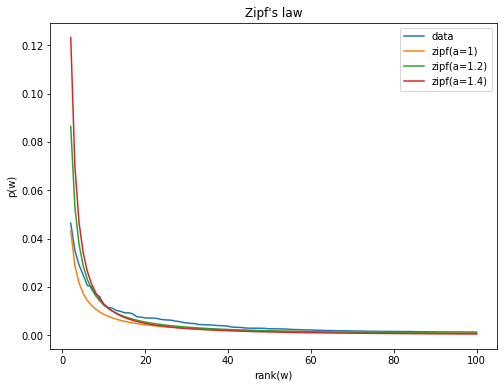

In [ ]:
import matplotlib.pyplot as plt
horizontal_points = np.arange(1, len(unifiedvocabulary)+1) # rank
word_frequencies = np.squeeze(unifiedvocabulary_totaloccurrencecounts[highest_totaloccurrences_indices])
vertical_points = word_frequencies / sum(word_frequencies)

a1 = 1
a2 = 1.2
a3 = 1.4
zipf_frequencies1 = np.power(horizontal_points.astype(float), -1 * a1)
zipf_points1 = zipf_frequencies1 / sum(zipf_frequencies1)

zipf_frequencies2 = np.power(horizontal_points.astype(float), -1 * a2)
zipf_points2 = zipf_frequencies2 / sum(zipf_frequencies2)

zipf_frequencies3 = np.power(horizontal_points.astype(float), -1 * a3)
zipf_points3 = zipf_frequencies3 / sum(zipf_frequencies3)

plt.figure(figsize=(8,6))
plt.title('Zipf\'s law')
plt.plot(horizontal_points[1:100], vertical_points[1:100])
plt.plot(horizontal_points[1:100], zipf_points1[1:100])

#plt.plot(horizontal_points[1:100], vertical_points[1:100])
plt.plot(horizontal_points[1:100], zipf_points2[1:100])

#plt.plot(horizontal_points[1:100], vertical_points[1:100])
plt.plot(horizontal_points[1:100], zipf_points3[1:100])

plt.xlabel('rank(w)')
plt.ylabel('p(w)')
plt.legend(['data', 'zipf(a=1)', 'zipf(a=1.2)', 'zipf(a=1.4)'], loc='best')
plt.show() 